In [1]:
import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

print(tf.__version__)

2.8.2


In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '/content/drive/MyDrive/project/MMS project/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.png':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))
low_img = []
path = '/content/drive/MyDrive/project/MMS project/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.png':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:11<00:00, 72.76it/s] 


In [3]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [4]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


In [5]:
def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),])
    return model

In [6]:
input_img=Input(shape=(256,256,3))
l1=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3=MaxPooling2D(padding='same')(l2)
l4=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l5=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l4)
l6=MaxPooling2D(padding='same')(l5)

l7=Conv2D (256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l6)
l7=residual_block_gen()(l7)
l8=UpSampling2D()(l7)
l9=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l8)
l10=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l9)
l11=add([l10,l5])
l12=UpSampling2D()(l11)
l13=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l12)
l14=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l13)
l15=add([l14,l2])

decoder=Conv2D (3,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l15)
#out= tf.keras.filters
autoencoder_residual=Model(input_img,decoder)
autoencoder_residual.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

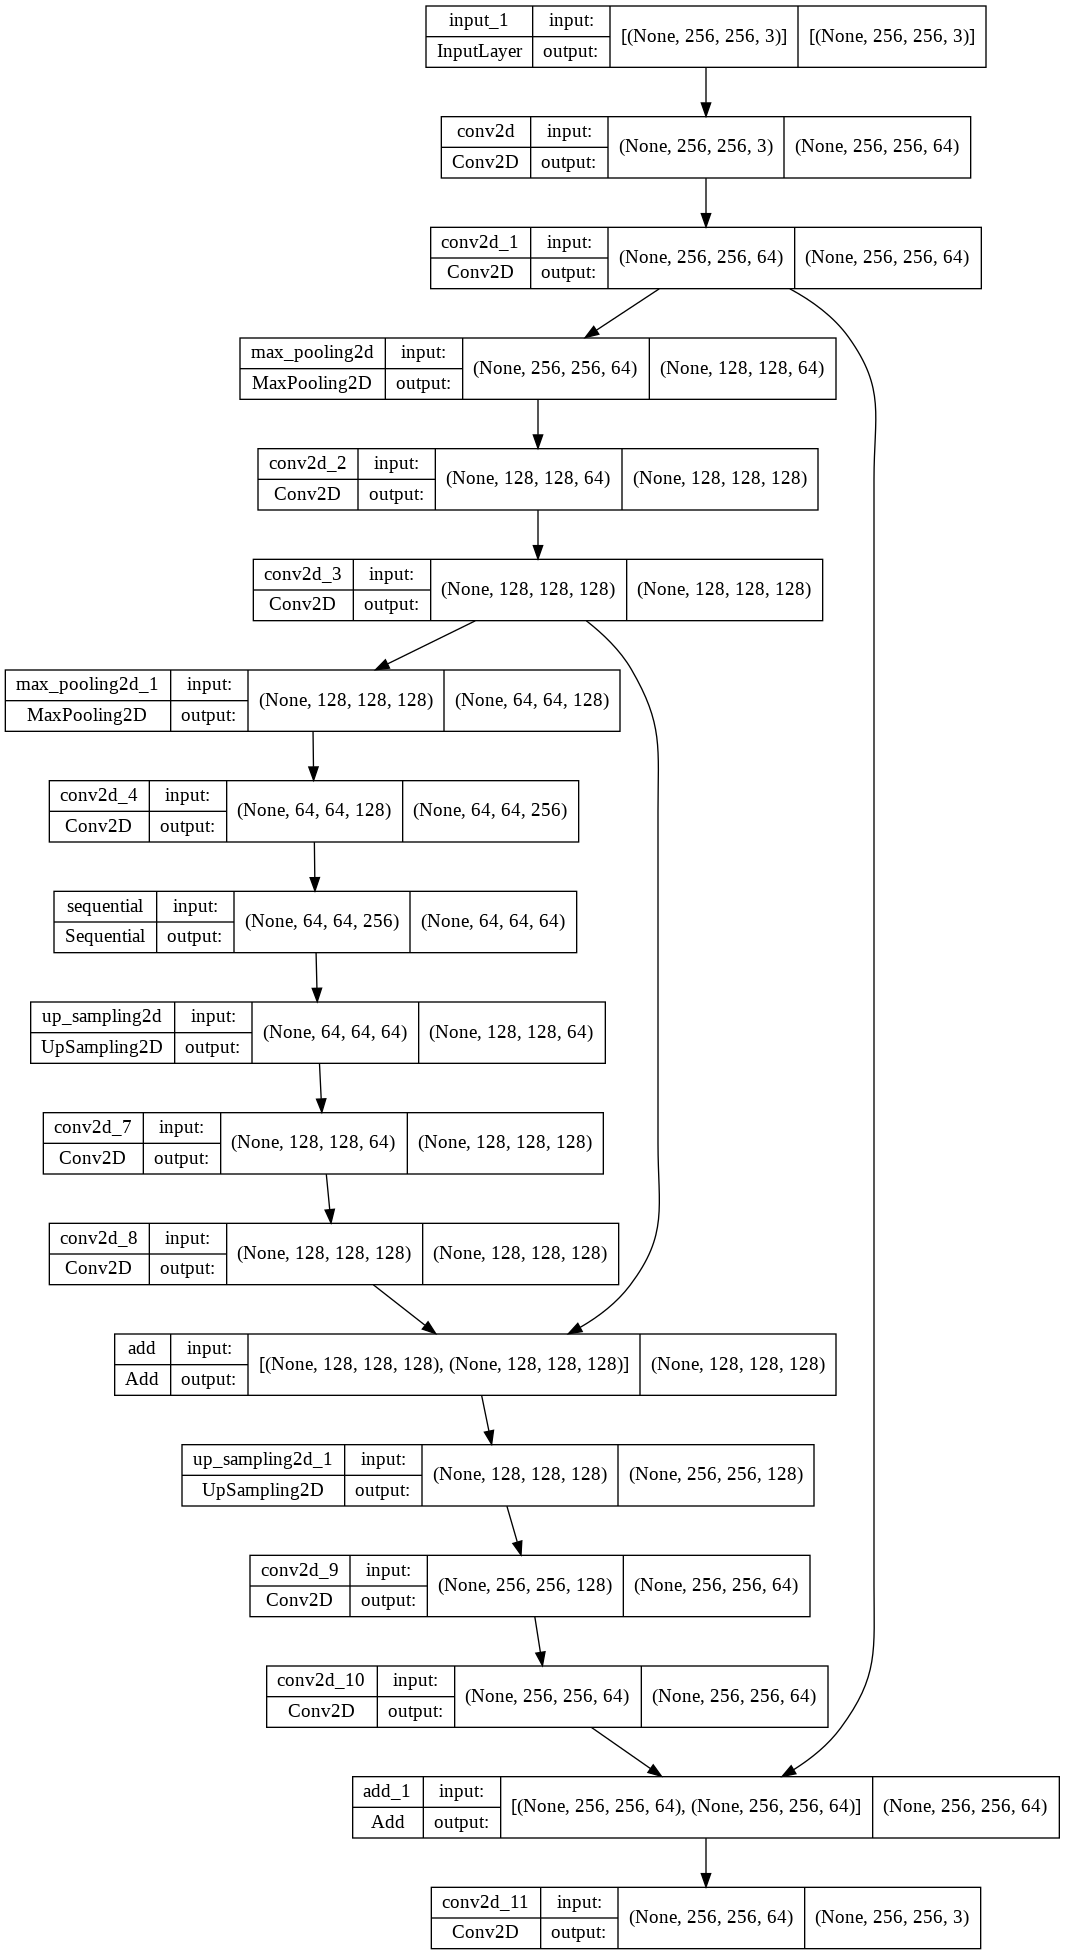

In [8]:
tf.keras.utils.plot_model(autoencoder_residual, to_file="model1.png", show_shapes=True)

In [9]:
autoencoder_residual.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [15]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)

In [16]:
autoencoder_residual.fit(train_low_image, train_high_image, epochs = 50, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image),callbacks=[es])

Epoch 1/50
700/700 [==============================] - 27s 39ms/step - loss: 0.0240 - acc: 0.8094 - val_loss: 0.0195 - val_acc: 0.8969
Epoch 2/50
700/700 [==============================] - 28s 40ms/step - loss: 0.0230 - acc: 0.8088 - val_loss: 0.0238 - val_acc: 0.7794
Epoch 3/50
700/700 [==============================] - 27s 39ms/step - loss: 0.0237 - acc: 0.8065 - val_loss: 0.0199 - val_acc: 0.9029
Epoch 4/50
700/700 [==============================] - 27s 38ms/step - loss: 0.0222 - acc: 0.8094 - val_loss: 0.0259 - val_acc: 0.7809
Epoch 4: early stopping


In [17]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [18]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(0,5):
    
    predicted = np.clip(autoencoder_residual.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)
    print('PSNR',PSNR(test_high_image[i],predicted),'dB')

Output hidden; open in https://colab.research.google.com to view.

In [19]:
autoencoder_residual.save("model1.h5")